# Team 23 - Gentrification in Crown Heights Brooklyn

## Motivation
A friend's personal experience. He has lived in the New York City for more than a decade.
He was complaining about he and his girlfriend had to move approxibately every 3 years because of the rent that had increased due to the gentribication. Eventually he got pushed out of Manhattan and currently lives in Brooklyn.

### What is Gentrification?
- Gentrification is the process of urban renewal of poor, underserved areas. 
- This is accompanied by the influx of people into the poorer neighborhoods. 
- Over time the services available in the area improve and the cost of living increases. 
- This results, poorer people who cannot afford to live there will be forced to move to poorer or more affordable neighborhoods.

- Gentrification can benefit an area by:
 - decreasing crime rate
 - increasing property and home values
 
- Gentrification can have negative consequence on area: 
 - forcing out low-income residents
 - leading to heightened difference in race and class
 
This process, gentrification, changes areas drastically over the course of several years.
We decided to look into gentrification of Crown Heights Brooklyn, New York, since Crown Heights, is among the 20 most gentrified areas in the US.

Below shows Crown Heights and three other areas in the Brooklyn as comparison

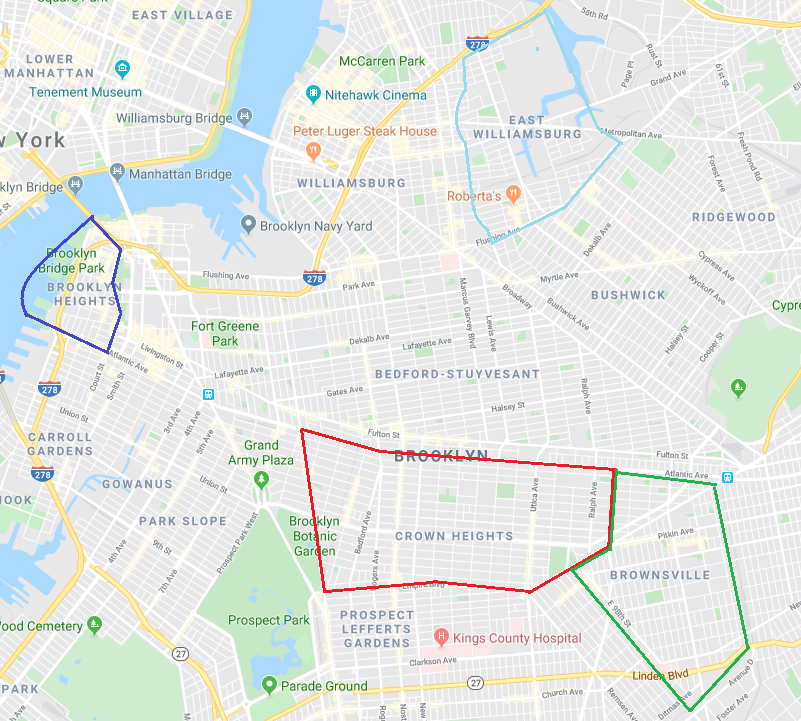

In [2]:
# Load library
%matplotlib inline
import os
import sqlite3
from sqlite3 import Error
import gzip
import pandas as pd

import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

import json
import plotly.express as px

from contextlib import closing
import os.path

# Helper functions
def create_connection(db_file, delete_db=False):
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

pd.set_option('display.max_columns', None)

In [83]:
# Use plotly to create interactive plot
# Coordinate is defined in geojson.io
df_2 = pd.DataFrame({"location":["BrooklynHights", "CrownHights", "Brownsville","EastWilliamsburg"], 
                     "colors":["Brooklyn Hights","Crown Hights","Brownsville","EastWilliamsburg"]})

with open('map.geojson') as response:
    nymap = json.load(response)

fig = px.choropleth_mapbox(df_2, geojson=nymap, locations='location', color='colors',
                           mapbox_style="carto-positron",
                           zoom=11.8, center = {"lat": 40.688739, "lon": -73.947650},
                           opacity=0.3
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Data description
### To study the problem we used multiple datasets which include:
 - **NYPD Complaint Data Historic**: This dataset includes crimes reported to the New  York City Police Department (NYPD) from 2006 to 2017.
  -  We used it to  provide insight of the crime rate in Crown Heights from 2006 through 2017.
  -  The dataset has 6,500,870 reported complaint including violations, misdemeanors, and felonies in the entire metro city area in this period.
 - **School Demographics**: Student demographic and enrollment data by school from 2005-06 through 2011-12 and 2013-14 through 2017-18. 
  -  We used school demographic snapshots to provide demographic population change information in Crown Heights as it is hard to find the demographics of the population in a certain area.
  -  The data shows there were 63 schools in this distric. Some of them closed due to poor performance and then merged with other school.
  -  The school demograpics data provides percentage of most of the racial groups and percentage of proverty class in each school.
 
 - **Brooklyn Home Sales**: This dataset contains home sale price in Brooklyn from 2003 to 2017. There were 390,883 houses sold in this Brooklyn.
  -  We used the to document price changes in Crown Heights from 2003 to 2017.
  -  The average house price was calcuated per year.
  
 NYPD Complain data is more than 2GB. In order to load the data in Jupyter Notebook, a database is created and linked to the notebook to prevent loading the entire datasets. 
 
 Reference:
 2013 - 2018_Demographic_Snapshot
 https://data.cityofnewyork.us/Education/2013-2018-Demographic-Snapshot-School/s52a-8aq6
 
 2018-2019_Demographic_Snapshot
 https://data.cityofnewyork.us/Education/2018-2019-Citywide-Demographic-Snapshot/3ydk-du45
 
 NYPD_Complaint_Data_Historic
 https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i
 
 Brooklyn Home Sales
 https://www.kaggle.com/tianhwu/brooklynhomes2003to2017

## Data Import

### Create Table in SQL database

In [4]:
if os.path.isfile('Brooklyn.db'):
    print('Brooklyn database exists')
else:
    db_file = 'Brooklyn.db'
    # with closing(create_connection(db_file, delete_db=True)) as conn:
    with closing(create_connection(db_file)) as conn:
        df = pd.read_csv('2006_-_2012_School_Demographics_and_Accountability_Snapshot.csv')
        df = df.rename(columns={"frl_percent": "Poverty_per","ell_percent": "ell_per"})
        df.to_sql('School_Demographics06_12', conn, if_exists='append', index=False)
        
        df = pd.read_csv('2013_-_2018_Demographic_Snapshot_School.csv')
        df = df.rename(columns={"Year": "schoolyear", "% Asian": "asian_per", 
                                "% Black": "black_per", "% Hispanic": "hispanic_per", 
                                "% Multiple Race Categories Not Represented": "MRCNR_per", 
                                "% White": "white_per", "% Students with Disabilities": "SwD_per", 
                                "% English Language Learners": "ell_per", "% Poverty": "Poverty_per"})
        df.to_sql('School_Demographics13_18', conn, if_exists='append', index=False)

        df = pd.read_csv('brooklyn_sales_map.csv', low_memory=False)
        df.to_sql('House_Sales', conn, if_exists='append', index=False)

        df = pd.read_csv('School_Location.csv')
        df.to_sql('School_Location', conn, if_exists='append', index=False)

        df = pd.read_csv('NYPD_Complaint_Data_Historic.csv', low_memory=False)
        df.to_sql('Crime', conn, if_exists='append', index=False)

Brooklyn database exists


### Getting the  Data
Query data from database

There different level of crimes describe in the NYPD Complain data, violation, misdemeanor and felony.
In this project, the violation is not consider as crime, therefore, only the misdemeanor and felony are aggregated and used to evaluate the gentrification.

The complaint data does not contain smaller area like Crown Heights and Brooklyn Heights. Therefore, in this project we leverage the latitude and longitude to locate such areas.

In [5]:
def queryCrime(name,year,coord):
    sql ="""select count(*) 
         from crime 
         where rpt_dt like ? and 
         Latitude > ? and Latitude < ? and 
         Longitude < ? and Longitude > ? and 
         LAW_CAT_CD in ('MISDEMEANOR', 'FELONY'); """
    with closing(sqlite3.connect("Brooklyn.db")) as conn:
        df_CrimeCount = pd.read_sql_query(sql, conn, params = (year,coord[name][0],coord[name][1],
                                                                coord[name][2],coord[name][3]))
    df_CrimeCount.columns = [name]
    
    return df_CrimeCount

def queryHousePrice(name,year):
    sql ="""select avg(sale_price) "Avg_Price" 
            from House_Sales 
            where year_of_sale like ? and
            upper(neighborhood) = ?; """
    with closing(sqlite3.connect("Brooklyn.db")) as conn:
        df_HousePrice = pd.read_sql_query(sql, conn, params = (year,name))
    df_HousePrice.columns = [name]
    
    return df_HousePrice

def queryDemo06_12(year):
    sql ="""select d.DBN, l.Lat_Lon, d.schoolyear, d.asian_per, d.black_per, d.hispanic_per, d.white_per, 
         d.ell_per, d.Poverty_per
         from School_Demographics06_12 d
         join School_Location l 
         using (DBN) 
         where DBN like '17k%' and schoolyear = ?;"""
    with closing(sqlite3.connect("Brooklyn.db")) as conn:
        df_Demo = pd.read_sql_query(sql, conn, params = ([year]))

    return df_Demo

def queryDemo013_18(year):
    sql ="""select d.DBN, l.Lat_Lon, d.schoolyear, d.asian_per, d.black_per, d.hispanic_per, d.white_per, 
         d.ell_per, d.Poverty_per
         from School_Demographics13_18 d
         join School_Location l 
         using (DBN) 
         where DBN like '17k%' and schoolyear = ?;"""
    with closing(sqlite3.connect("Brooklyn.db")) as conn:
        df_Demo = pd.read_sql_query(sql, conn, params = ([year]))
    
    return df_Demo

In [6]:
## Crime count
# Coord S,N,E,W
coord = {
    "Crown Heights" : [40.661069,40.681040,-73.919929,-73.964345],
    "Brooklyn Heights" : [40.689590,40.704020,-73.990815,-74.002048],
    "Brownsville" : [40.651297,40.676721,-73.900341,-73.924674],
    "East Williamsburg" : [40.703146, 40.725916, -73.920845, -73.942260]
}
cyears = ['%2006','%2007','%2008','%2009','%2010','%2011','%2012','%2013','%2014','%2015','%2016','%2017']
df_CH = pd.DataFrame()
df_BH = pd.DataFrame()
df_BV = pd.DataFrame()
df_EW = pd.DataFrame()
for i,v in enumerate(cyears):
    df_CH = df_CH.append(queryCrime("Crown Heights",v,coord), ignore_index=True)
    df_BH = df_BH.append(queryCrime("Brooklyn Heights",v,coord), ignore_index=True)
    df_BV = df_BV.append(queryCrime("Brownsville",v,coord), ignore_index=True)
    df_EW = df_EW.append(queryCrime("East Williamsburg",v,coord), ignore_index=True)
df_crime = pd.concat([df_CH, df_BH, df_BV, df_EW], axis=1)
df_crime.index = [2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]


In [7]:
## Crime Data count only 'MISDEMEANOR', 'FELONY' for East Williamsburg

sql13 ="""select count(*) "Num_Crime" from crime where rpt_dt like ? and 
        Latitude > 40.703146 and Latitude < 40.725916 and Longitude < -73.920845 and Longitude > -73.942260 
        and LAW_CAT_CD in ('MISDEMEANOR', 'FELONY') limit 5; """
conn = sqlite3.connect("Brooklyn.db")
c = conn.cursor()
df13 = pd.DataFrame(columns=['Num_Crime'])
cyears = ['%2006','%2007','%2008','%2009','%2010','%2011','%2012','%2013','%2014','%2015','%2016','%2017']
cyear = [2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]
for i,v in enumerate(cyears):
    df13 = df13.append(pd.read_sql_query(sql13, conn, params = ([v])), ignore_index=False)
    df13.rename(index={0: cyear[i]}, inplace = True)
conn.close()

In [26]:
## House Pricing
year = [2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]
df_CH = pd.DataFrame()
df_BH = pd.DataFrame()
df_BV = pd.DataFrame()
df_EW = pd.DataFrame()
for i,v in enumerate(year):
    df_CH = df_CH.append(queryHousePrice('CROWN HEIGHTS',v), ignore_index=True)
    df_BH = df_BH.append(queryHousePrice('BROOKLYN HEIGHTS',v), ignore_index=True)
    df_BV = df_BV.append(queryHousePrice('BROWNSVILLE',v), ignore_index=True)
    df_EW = df_EW.append(queryHousePrice('WILLIAMSBURG-EAST',v), ignore_index=True)
df_HousePrice = pd.concat([df_CH, df_BH, df_BV, df_EW], axis=1)
df_HousePrice.index = [2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]

In [9]:
## Demographic info - 2005-2012
dyears = [20052006, 20062007, 20072008, 20082009, 20092010, 20102011, 20112012]
df_Demo1 = pd.DataFrame()
for i,v in enumerate(dyears):
    df_Demo1 = df_Demo1.append(queryDemo06_12(v), ignore_index=True)
# df_Demo1.rename(columns={"frl_percent": "Poverty_per","ell_percent": "ell_per"}, inplace = True)
df_Demo1.replace({'schoolyear': {20052006:2005, 20062007:2006, 20072008:2007, 20082009:2008, 20092010:2009,
                             20102011:2010, 20112012:2011}}, inplace = True)

In [10]:
## Demographic info - 2013-2017
dyears = ['2013-14', '2014-15', '2015-16', '2016-17', '2017-18']
df_Demo2 = pd.DataFrame()
for i,v in enumerate(dyears):
    df_Demo2 = df_Demo2.append(queryDemo013_18(v), ignore_index=True)
# df_Demo1.rename(columns={"frl_percent": "Poverty_per","ell_percent": "ell_per"}, inplace = True)
df_Demo2.replace({'schoolyear': {'2013-14':'2013', '2014-15':'2014', '2015-16':'2015', 
                                 '2016-17':'2016', '2017-18':'2017'}}, inplace = True)

In [11]:
# schoolList = ['17K002', '17K006', '17K012', '17K022', '17K061', '17K091', '17K246', '17K092', '17K122', '17K138', 
#               '17K161', '17K167', '17K181', '17K390', '17K189', '17K191', '17K221', '17K241', '17K249', '17K289', 
#               '17K316', '17K334', '17K340', '17K352', '17K353', '17K354', '17K375', '17K382', '17K391', '17K394', 
#               '17K397', '17K398', '17K399', '17K408', '17K440', '17K459', '17K469', '17K470', '17K479', '17K484', 
#               '17K489', '17K524', '17K528', '17K531', '17K533', '17K537', '17K539', '17K543', '17K544', '17K546', 
#               '17K547', '17K548', '17K568', '17K587', '17K590', '17K600', '17K625', '17K751', '17K770', '17K532', 
#               '17K705', '17K745', '17K722']

## Exploratory anlysis  

### Crime rates over the years in Crown Heights 
-General trend is a decrease in crime rates over the years (2006-2017) especially after 2011
- Reduction in crime may be indicative of gentrification because it has been stated in the literature that low income people are more likely to commit crimes. 
- The move of more affluent groups into the area along  the rise in cost of living (gentrification) my cause local criminals to relocate.

In [12]:
df_crime.head()

,Crown Heights,Brooklyn Heights,Brownsville,East Williamsburg
2006,13807,806,9058,2116
2007,14683,1094,9094,2154
2008,14139,921,9733,2354
2009,13811,958,10379,2263
2010,14285,912,10212,2296


Text(0.5, 1.0, 'Crime Trend')

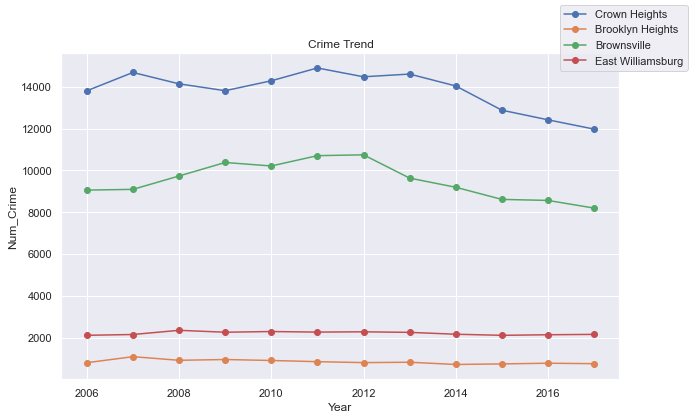

In [51]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_crime, marker='o')
ax.set(xlabel="Year", ylabel="Num_Crime")
ax.figure.legend(["Crown Heights", "Brooklyn Heights", "Brownsville", "East Williamsburg"])
plt.title("Crime Trend")


### Housing prices over the years in Crown Heights 
-General trend is an increase in the average housing prices over the years (2003-2017)
 - Increase in housing prices may be indicative of gentrification because the rise in house prices indicates the incoming of more affluent groups and will result in the relocation of the poor. 


In [33]:
df_HousePrice

,CROWN HEIGHTS,BROOKLYN HEIGHTS,BROWNSVILLE,WILLIAMSBURG-EAST
2003,304605.854604,5.425111e+05,171579.593182,2.603322e+05
2004,268965.462349,9.845188e+05,218850.935484,2.948448e+05
2005,429347.571308,6.864914e+05,256815.165236,4.014180e+05
2006,469531.500426,1.132402e+06,352113.518433,5.198438e+05
2007,461363.482833,1.453078e+06,467211.991713,4.838143e+05
2008,497129.590580,9.145313e+05,333781.853659,4.361266e+05
2009,316214.511848,6.770854e+05,265545.516854,4.290736e+05
2010,293970.967742,1.357675e+06,309261.577778,4.638118e+05
2011,383622.483912,9.914119e+05,258726.058824,4.061511e+05
2012,454890.646988,1.459534e+06,257241.091463,6.069894e+05


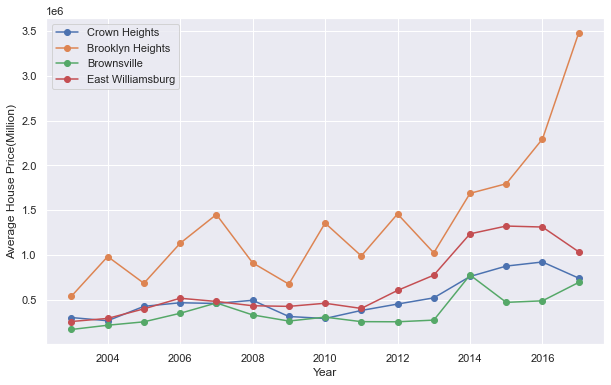

In [36]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df_HousePrice,'-o')
ax.set(xlabel="Year", ylabel="Average House Price(Million)")
ax.legend(["Crown Heights", "Brooklyn Heights", "Brownsville", "East Williamsburg"])

Text(2017.5, 15400, '???')

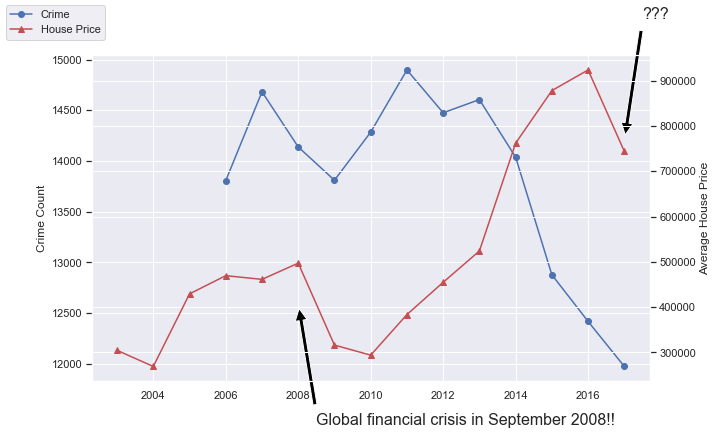

In [68]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df_crime.index, df_crime["Crown Heights"], marker='o')
ax2 = ax.twinx()
ax2.plot(df_HousePrice.index, df_HousePrice["CROWN HEIGHTS"], marker='^', color='r')

ax.set_ylabel('Crime Count')
ax2.set_ylabel('Average House Price')
ax.figure.legend(['Crime','House Price'],loc='upper left')

ax.annotate('Global financial crisis in September 2008!!', xy=(2008, 12600), xytext=(2008.5, 11400),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=16)
ax.annotate('???', xy=(2017, 14200), xytext=(2017.5, 15400),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=16)

In [141]:
# Use plotly to create interactive plot
# Coordinate is defined in geojson.io
df_3 = pd.DataFrame({"location":["CrownHights"], 
                     "colors":["Crown Hights"]})
df_4 = pd.DataFrame({"location":["Public School 316","Public School 138","Public School 191"], 
                     "colors":["Public School 316","Public School 138","Public School 191"],
                     "lats":[40.67461691884209,40.673925270452145,40.67138645250611],
                     "longs":[-73.960862159729,-73.95134568214417,-73.92414808273315]})

fig = px.scatter_mapbox(
    df_4,
    lat=lats,
    lon=longs,
    color="colors",
    mapbox_style="carto-positron",
    zoom=13.4, 
    center = {"lat": 40.671739, "lon": -73.941650}                
    )
fig_px = px.choropleth_mapbox(
    df_3, 
    geojson=nymap, 
    locations='location', 
    color='colors',
    opacity=0.3
    )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.add_trace(fig_px.data[0])

fig.show()

In [30]:
# dfg.get_group('17K539')

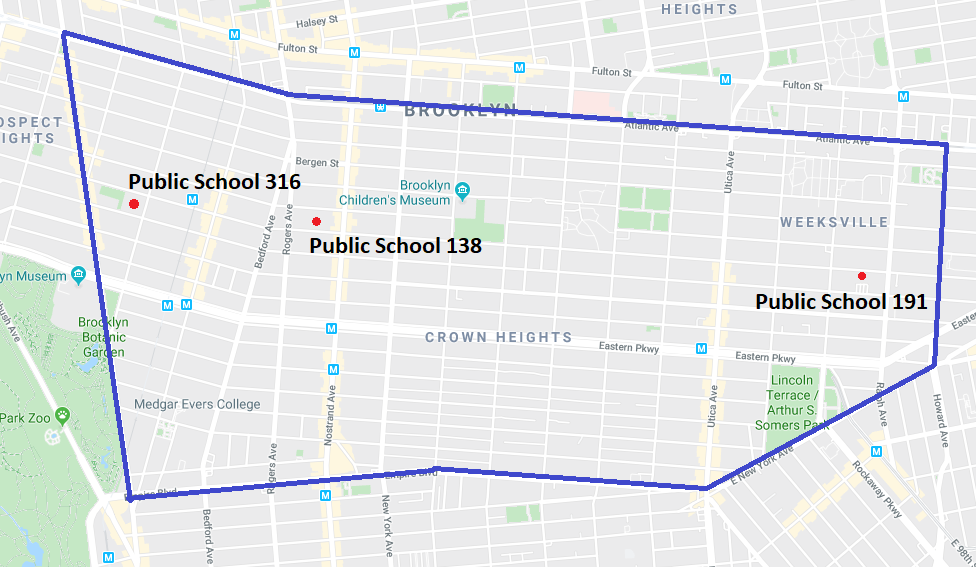

### School demographic information
- The percentage of the students in poverty starts to  decrease in 2009. 
 -  This indicate gentrification as it implies the presence of more affluent and the displacement of lower-income families.
- The percentage of Hispanic, and white start increasing in the west of Crown Heights.
- There is a slight decrease in African Americans race.  
 -  This ethnic change/racial displacement is a common outcome of gentrification.

In [155]:
df_Demo = df_Demo1.append(df_Demo2)
df_Demo['schoolyear'] = df_Demo['schoolyear'].astype('int')

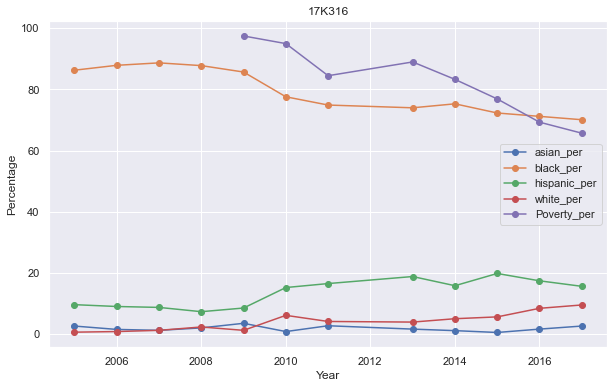

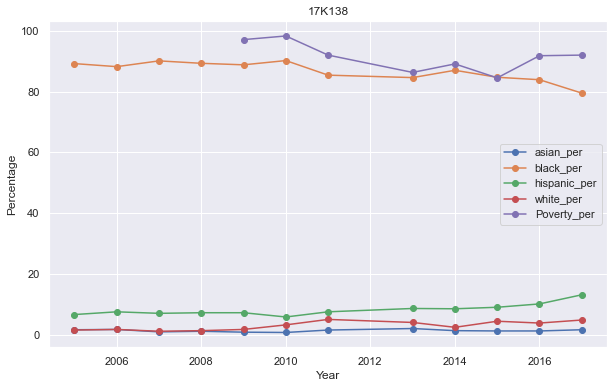

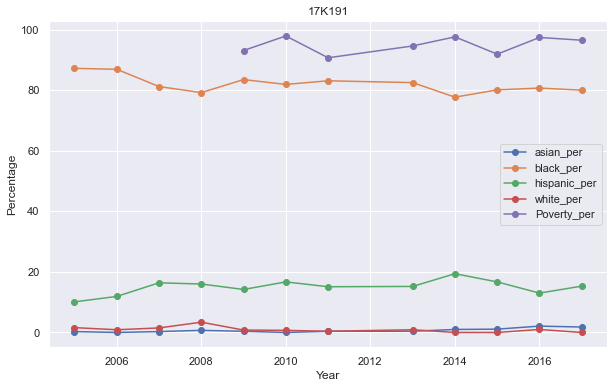

In [171]:
schoolList = ['17K316', '17K138', '17K191']
for i in schoolList:
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(df_Demo[df_Demo['DBN'] == i]['schoolyear'], 
            df_Demo[df_Demo['DBN'] == i][['asian_per', 'black_per','hispanic_per', 'white_per', 'Poverty_per']], 
            marker='o')
    ax.set(xlabel="Year", ylabel="Percentage")
    ax.legend(['asian_per', 'black_per','hispanic_per', 'white_per', 'Poverty_per'])
    ax.set_title(i)

In [170]:
df_Demo[df_Demo['DBN'] == '17K316']

,DBN,Lat_Lon,schoolyear,asian_per,black_per,hispanic_per,white_per,ell_per,Poverty_per
18,17K316,"40.674532, -73.960701",2005,2.6,86.3,9.6,0.6,6.2,None
71,17K316,"40.674532, -73.960701",2006,1.5,87.9,9.0,0.8,6.2,None
127,17K316,"40.674532, -73.960701",2007,1.2,88.7,8.7,1.2,6.6,None
178,17K316,"40.674532, -73.960701",2008,2.0,87.8,7.3,2.3,4.0,None
227,17K316,"40.674532, -73.960701",2009,3.5,85.7,8.5,1.2,4.7,97.5
276,17K316,"40.674532, -73.960701",2010,0.8,77.6,15.2,6.1,4.6,95
327,17K316,"40.674532, -73.960701",2011,2.7,74.9,16.5,4.1,6.5,84.5
18,17K316,"40.674532, -73.960701",2013,1.6,74.0,18.8,3.9,4.2,89
66,17K316,"40.674532, -73.960701",2014,1.1,75.3,15.8,5.0,3.3,83.3
115,17K316,"40.674532, -73.960701",2015,0.5,72.3,19.8,5.6,4.0,76.9


In [ ]:
df_Demo.loc("DBN")

## Conclusion
It does appear that gentrification has had a significant effect on crime rate, housing prices, and demographic changes.
The data suggest that there is a strong inverse relationship between housing prices and crime rates. 
Our data also indicates the gentrification is progressing from west to east across Crown Heights.

Also it is consistance with my friend's experience of having to relocation further east over time because of cost of living.